In [2]:
import numpy as np
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.preprocessing import sequence

%matplotlib inline

C:\Program Files\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
from preprocess import divide_to_train_and_test, one_hot
from confusion_matrix import print_confusion_matrix

In [4]:
import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"] = '0' #use GPU with ID=0
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5 # maximun alloc gpu50% of MEM
config.gpu_options.allow_growth = True #allocate dynamically
sess = tf.Session(config = config)

In [5]:
def load_from_directory(texts_directory, images_directory, target_names, max_files_in_one_category=30000):
    file_texts = []
    targets = []
    
    for root, dirs, files in os.walk(images_directory):
        number_used_files = 0
        for name in files:
            if number_used_files < max_files_in_one_category:
            
                name_without_extenstion, _ = os.path.splitext(name)
                
                _, cur_target = os.path.split(root)
                cur_target = target_names.index(cur_target)
            
                text_name = name_without_extenstion + ".txt"
                cur_text_path =  os.path.join(texts_directory, text_name)
                print(cur_text_path)
                
                try:
                    with open(cur_text_path, encoding="utf-16") as file:
                
                        # считываем файл построчно
                        file_text = ""
                        for line in file.readlines():
                            file_text += (line)
                        if file_text != "" and file_text != " ":
                            file_texts.append(file_text[2:])
                            targets.append(cur_target)
                
                            number_used_files += 1            
                except:
                    print("PROBLEM WITH FILE", cur_text_path)
                
    return file_texts, targets


In [6]:
#let's try to write another version of "load_embeddins"

def load_embeddings(emb_path, max_embeddings_count=100000):
    emb_word_id_to_vector = {}
    word_to_id = {}
    current_word_id = 0
    with open(emb_path, 'r', encoding='utf-8') as f:
        for line in f:
            if current_word_id <= max_embeddings_count:
                line_split = line.strip().split(" ")
                word = line_split[0]
                word_emb = np.array(line_split[1:], dtype=float)
            
                if word_emb.shape != (300,):
                    print("ERROR! Shape is", word_emb.shape, word)
                    continue
            
                word_to_id[word] = current_word_id
                emb_word_id_to_vector[current_word_id] = word_emb
                current_word_id += 1
            else:
                break
            
    return emb_word_id_to_vector, word_to_id

In [7]:
CATEGORIES_COUNT = 2

In [8]:
%%time
file_texts, targets = load_from_directory(texts_directory="D:/svruchtel/DATA/France_New/Texts",
                                         images_directory="D:/svruchtel/DATA/France_New_ByMeaningLarge", 
                                         target_names = ["AllTransport", "Restaurant"])

D:/svruchtel/DATA/France_New/Texts\000001.txt
D:/svruchtel/DATA/France_New/Texts\000002.txt
D:/svruchtel/DATA/France_New/Texts\000003.txt
D:/svruchtel/DATA/France_New/Texts\000004.txt
D:/svruchtel/DATA/France_New/Texts\000005.txt
D:/svruchtel/DATA/France_New/Texts\000300.txt
D:/svruchtel/DATA/France_New/Texts\000301.txt
D:/svruchtel/DATA/France_New/Texts\000302.txt
D:/svruchtel/DATA/France_New/Texts\000303.txt
D:/svruchtel/DATA/France_New/Texts\000304.txt
D:/svruchtel/DATA/France_New/Texts\000305.txt
D:/svruchtel/DATA/France_New/Texts\000306.txt
D:/svruchtel/DATA/France_New/Texts\000307.txt
D:/svruchtel/DATA/France_New/Texts\000308.txt
D:/svruchtel/DATA/France_New/Texts\000309.txt
D:/svruchtel/DATA/France_New/Texts\000310.txt
D:/svruchtel/DATA/France_New/Texts\000311.txt
D:/svruchtel/DATA/France_New/Texts\000312.txt
D:/svruchtel/DATA/France_New/Texts\000313.txt
D:/svruchtel/DATA/France_New/Texts\000314.txt
D:/svruchtel/DATA/France_New/Texts\000315.txt
D:/svruchtel/DATA/France_New/Texts

In [9]:
%%time
emb_word_id_to_vector, word_to_id = load_embeddings("D:/svruchtel/EMBEDDINGS/wiki.fr.vec", 
                                    max_embeddings_count=300000)

ERROR! Shape is (1,) 1152449
ERROR! Shape is (299,) -0.28063
ERROR! Shape is (299,) 0.43353
ERROR! Shape is (299,) -0.0038925
ERROR! Shape is (299,) -0.035726
ERROR! Shape is (299,) -0.20013
ERROR! Shape is (299,) -0.46027
ERROR! Shape is (299,) -0.20699
ERROR! Shape is (299,) 0.2856
ERROR! Shape is (299,) 0.16302
ERROR! Shape is (299,) 0.23343
ERROR! Shape is (299,) -0.02369
ERROR! Shape is (299,) 0.10821
ERROR! Shape is (299,) 0.2008
ERROR! Shape is (299,) 0.18062
ERROR! Shape is (299,) 0.12528
ERROR! Shape is (299,) 0.17735
Wall time: 1min 1s


In [20]:
def change_words_to_their_embeddings(file_texts, emb_word_id_to_vector, word_to_id):
    X_emb = []
    
    for text in file_texts:
        embedded_text = []

        words_count = 0

        words = [word for word in text.strip().replace(":", " ").replace(".", " ").replace("!", " ").replace("?", " ").replace(",", " ").replace(";", " ").replace("\n", " ").split(" ") if word != "" ]
        for word in words:
            if words_count < 100:
                if word in word_to_id:
                    embedded_text.append(emb_word_id_to_vector[word_to_id[word]])
                    words_count += 1
                elif word.lower() in word_to_id:
                    embedded_text.append(emb_word_id_to_vector[word_to_id[word.lower()]])
                    words_count += 1
                else:
                    #embedded_text.append(emb_word_id_to_vector[word_to_id["nul"]])
                    print("There is no embedding for word", word)
            else:
                break
            
        while words_count < 100:
            embedded_text.append(emb_word_id_to_vector[word_to_id["nul"]])
            words_count += 1
    
        X_emb.append(embedded_text)
    return np.array(X_emb)

In [11]:
len(file_texts)

3309

In [12]:
file_texts[0]

'RCOS ETOILE\n53. AVENUE DE LA GRANDE ARMEE\n75116 PARIS\nTEL: 0145004023\nFAX: 0145004029--\nE-MAIL : f dsp6wnge.fr HERARD JEROME\nREG: 49841888800018 82 RUE XAVIER DE MAISTRE\nTVA: FR 27498 418 888\nca*talde**j* 92500 RUEIL MALMAISON\nI FACTURE I WCUENT | OPERATEUR DATE PAGÊ"\nI 4014331 I 8396 | 1 DANIELLE DARCOS 19/05/2017 1\nREFERENCE| DESKNAT1QN QUANTITE PRD( UNTTT.T.C. MONTANTTTC T.VA.%\ntOC SWING AG-903-EG 2DCJF****** 1,00 1000,004 1000.00 € 20,00\nDU 1*60017 N11*10017\n600 nfi INUQ 43K IMS SUPPiaenARE\nFARE LES t*ÆAUX CHEZ DARCOS\nTOUS LES 500 KMSMUQ\nFORFAIT ASSISTANCE FORFAIT 1 DEPANNAGE PARS 1,00 30,00 € 30,00 € 20.00\nTAUX BASE HT. MONTANT T VA ~l BRUT TTC. 1030,00 €\n20.00 858,334 171.674\nNET HT. 858.334\nTOTAL T.VA 171.674\n___ NETT.T.C. 1030,004\nRESTE A PAYER__0,00 4\nB—67 |C*n**NCM* I 1WW<\nMERCI DE VOTRE VISITE\nA BIENTOT\nr~imî‘TiniiB gniim n�i>iTfr ~—r—i—*---"rr--—• * "•■•••-n t-----\n'

In [21]:
%%time
X_emb = change_words_to_their_embeddings(file_texts, emb_word_id_to_vector, word_to_id)

There is no embedding for word RCOS
There is no embedding for word 53
There is no embedding for word 75116
There is no embedding for word 0145004023
There is no embedding for word 0145004029--
There is no embedding for word E-MAIL
There is no embedding for word dsp6wnge
There is no embedding for word HERARD
There is no embedding for word 49841888800018
There is no embedding for word 82
There is no embedding for word 27498
There is no embedding for word 418
There is no embedding for word 888
There is no embedding for word ca*talde**j*
There is no embedding for word 92500
There is no embedding for word WCUENT
There is no embedding for word |
There is no embedding for word PAGÊ"
There is no embedding for word 4014331
There is no embedding for word 8396
There is no embedding for word |
There is no embedding for word 1
There is no embedding for word 19/05/2017
There is no embedding for word 1
There is no embedding for word REFERENCE|
There is no embedding for word DESKNAT1QN
There is no emb

In [22]:
X_emb.shape

(3309, 100, 300)

In [23]:
len(targets)

3309

In [24]:
X_train, targets_train, X_test, targets_test = divide_to_train_and_test(X_emb, targets, num_categories=CATEGORIES_COUNT)
# one-hot encoding for targets
y_train = one_hot(targets_train, classes_count=CATEGORIES_COUNT)
y_test = one_hot(targets_test, classes_count=CATEGORIES_COUNT)

In [25]:
print(X_train[0][0][:5])
print(X_train[1][0][:5])
print(X_train[100][0][:5])

[-1.0265    0.069335 -0.07847   0.25446  -0.17015 ]
[ 0.08804 -0.13418  0.1006   0.18939  0.13879]
[-0.040728  0.34434  -0.74928  -0.29649   0.21252 ]


In [26]:
X_train.shape

(2977, 100, 300)

### LET'S RUN LSTM MODELS

### 1

In [27]:
%%time
# create the model
categories_count = CATEGORIES_COUNT

model = Sequential()
model.add(LSTM(100, input_shape=X_train[0].shape))
model.add(Dense(categories_count, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=0, mode='auto')
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=100, callbacks=[callback])

# Final evaluation of the model
test_scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f" % (test_scores[1]))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 160,602
Trainable params: 160,602
Non-trainable params: 0
_________________________________________________________________
None
Train on 2977 samples, validate on 332 samples
Epoch 1/200
2977/2977 [==============================] - 20s 7ms/step - loss: 0.6909 - acc: 0.5583 - val_loss: 0.6871 - val_acc: 0.5813
Epoch 2/200
2977/2977 [==============================] - 19s 6ms/step - loss: 0.6747 - acc: 0.5808 - val_loss: 0.6946 - val_acc: 0.5813
Epoch 3/200
2977/2977 [==============================] - 18s 6ms/step - loss: 0.6757 - acc: 0.5808 - val_loss: 0.6894 - val_acc: 0.5813
Epoch 4/200
2977/2977 [==============================] - 18s 6ms/step - 

TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[1726    3]
 [   6 1242]]
Normalized confusion matrix
[[0.99826489 0.00173511]
 [0.00480769 0.99519231]]


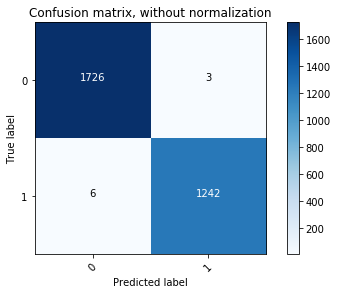

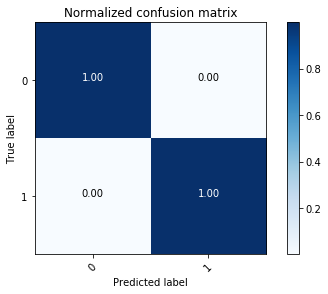

TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[187   6]
 [  2 137]]
Normalized confusion matrix
[[0.96891192 0.03108808]
 [0.01438849 0.98561151]]


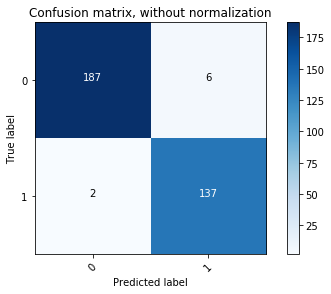

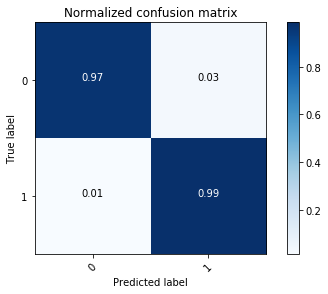

In [28]:
# draw confusion matrix
print("TRAIN CONFUSION MATRIX")
y_pred_train = model.predict(X_train)
print_confusion_matrix(X_train, y_train.argmax(axis=1), y_pred_train.argmax(axis=1), categories_count=CATEGORIES_COUNT)
print("TEST CONFUSION MATRIX")
y_pred_test = model.predict(X_test)
print_confusion_matrix(X_test, y_test.argmax(axis=1), y_pred_test.argmax(axis=1), categories_count=CATEGORIES_COUNT)

In [29]:
print("Val accuracy: %.4f" % (test_scores[1]))

Val accuracy: 0.9759


In [30]:
# predict results and write into file

In [31]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

file_path_train_X = "./LSTM_results_word_emb/France_ByMeaningLarge_1st_net_train_X_100_words.npy"
file_path_test_X = "./LSTM_results_word_emb/France_ByMeaningLarge_1st_net_test_X_100_words.npy"

file_path_train_y = "./LSTM_results_word_emb/France_ByMeaningLarge_1st_net_train_y.npy"
file_path_test_y = "./LSTM_results_word_emb/France_ByMeaningLarge_1st_net_test_y.npy"

np.save(file_path_train_X, train_predict)
np.save(file_path_test_X, test_predict)
np.save(file_path_train_y, y_train)
np.save(file_path_test_y, y_test)

### 2

In [33]:
%%time
# Lets try one another architecture

categories_count = CATEGORIES_COUNT

model = Sequential()
model.add(LSTM(100, input_shape=X_train[0].shape))
model.add(Dropout(0.2))
model.add(Dense(categories_count, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=0, mode='auto')
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=100, callbacks=[callback])

# Final evaluation of the model
test_scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f" % (test_scores[1]))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 202       
Total params: 160,602
Trainable params: 160,602
Non-trainable params: 0
_________________________________________________________________
None
Train on 2977 samples, validate on 332 samples
Epoch 1/200
2977/2977 [==============================] - 21s 7ms/step - loss: 0.7015 - acc: 0.5435 - val_loss: 0.6863 - val_acc: 0.5813
Epoch 2/200
2977/2977 [==============================] - 18s 6ms/step - loss: 0.6777 - acc: 0.5781 - val_loss: 0.6887 - val_acc: 0.5813
Epoch 3/200
2977/2977 [==============================] - 18s 6ms/step - loss

TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[1725    4]
 [   2 1246]]
Normalized confusion matrix
[[0.99768652 0.00231348]
 [0.00160256 0.99839744]]


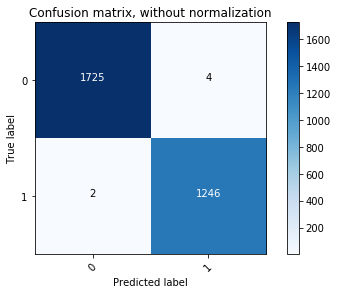

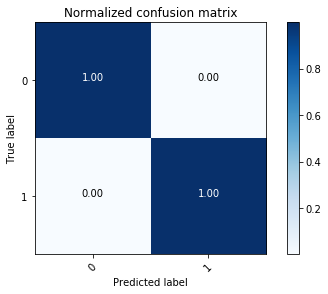

TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[182  11]
 [  1 138]]
Normalized confusion matrix
[[0.94300518 0.05699482]
 [0.00719424 0.99280576]]


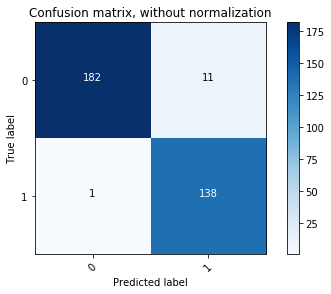

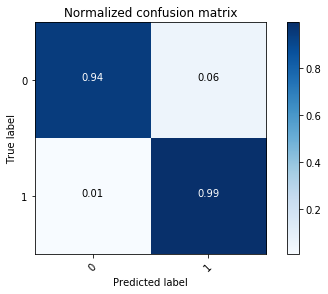

In [34]:
# draw confusion matrix
print("TRAIN CONFUSION MATRIX")
y_pred_train = model.predict(X_train)
print_confusion_matrix(X_train, y_train.argmax(axis=1), y_pred_train.argmax(axis=1), categories_count=CATEGORIES_COUNT)
print("TEST CONFUSION MATRIX")
y_pred_test = model.predict(X_test)
print_confusion_matrix(X_test, y_test.argmax(axis=1), y_pred_test.argmax(axis=1), categories_count=CATEGORIES_COUNT)

In [35]:
print("Val accuracy: %.4f" % (test_scores[1]))

Val accuracy: 0.9639


In [36]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

file_path_train_X = "./LSTM_results_word_emb/France_ByMeaningLarge_2nd_net_train_X_100_words.npy"
file_path_test_X = "./LSTM_results_word_emb/France_ByMeaningLarge_2nd_net_test_X_100_words.npy"

file_path_train_y = "./LSTM_results_word_emb/France_ByMeaningLarge_2nd_net_train_y.npy"
file_path_test_y = "./LSTM_results_word_emb/France_ByMeaningLarge_2nd_net_test_y.npy"

np.save(file_path_train_X, train_predict)
np.save(file_path_test_X, test_predict)
np.save(file_path_train_y, y_train)
np.save(file_path_test_y, y_test)

### 3

In [37]:
%%time

categories_count = CATEGORIES_COUNT

model = Sequential()
model.add(LSTM(100, input_shape=X_train[0].shape, recurrent_dropout=0.2))
model.add(Dense(categories_count, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=0, mode='auto')
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=100, callbacks=[callback])

# Final evaluation of the model
test_scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f" % (test_scores[1]))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 202       
Total params: 160,602
Trainable params: 160,602
Non-trainable params: 0
_________________________________________________________________
None
Train on 2977 samples, validate on 332 samples
Epoch 1/200
2977/2977 [==============================] - 20s 7ms/step - loss: 0.6860 - acc: 0.5647 - val_loss: 0.7061 - val_acc: 0.4187
Epoch 2/200
2977/2977 [==============================] - 17s 6ms/step - loss: 0.6802 - acc: 0.5532 - val_loss: 0.6895 - val_acc: 0.5813
Epoch 3/200
2977/2977 [==============================] - 19s 6ms/step - loss: 0.6751 - acc: 0.5754 - val_loss: 0.6904 - val_acc: 0.5813
Epoch 4/200
2977/2977 [==============================] - 19s 6ms/step - 

TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[1725    4]
 [   6 1242]]
Normalized confusion matrix
[[0.99768652 0.00231348]
 [0.00480769 0.99519231]]


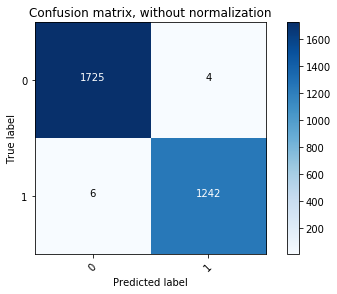

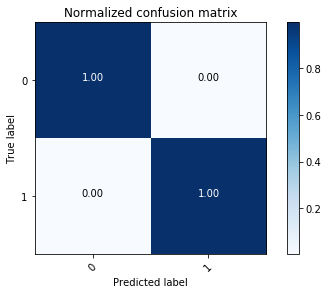

TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[187   6]
 [  2 137]]
Normalized confusion matrix
[[0.96891192 0.03108808]
 [0.01438849 0.98561151]]


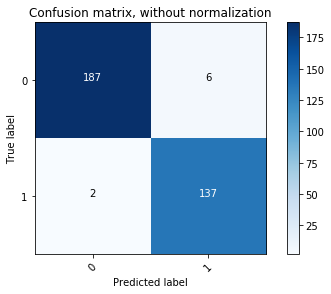

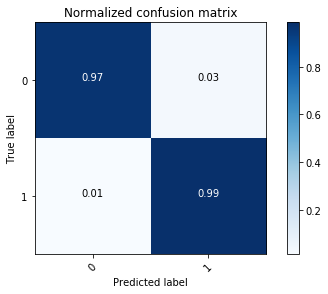

In [38]:
# draw confusion matrix
print("TRAIN CONFUSION MATRIX")
y_pred_train = model.predict(X_train)
print_confusion_matrix(X_train, y_train.argmax(axis=1), y_pred_train.argmax(axis=1), categories_count=CATEGORIES_COUNT)
print("TEST CONFUSION MATRIX")
y_pred_test = model.predict(X_test)
print_confusion_matrix(X_test, y_test.argmax(axis=1), y_pred_test.argmax(axis=1), categories_count=CATEGORIES_COUNT)

In [39]:
print("Val accuracy: %.4f" % (test_scores[1]))

Val accuracy: 0.9759


In [40]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

file_path_train_X = "./LSTM_results_word_emb/France_ByMeaningLarge_3rd_net_train_X_100_words.npy"
file_path_test_X = "./LSTM_results_word_emb/France_ByMeaningLarge_3rd_net_test_X_100_words.npy"

file_path_train_y = "./LSTM_results_word_emb/France_ByMeaningLarge_3rd_net_train_y.npy"
file_path_test_y = "./LSTM_results_word_emb/France_ByMeaningLarge_3rd_net_test_y.npy"

np.save(file_path_train_X, train_predict)
np.save(file_path_test_X, test_predict)
np.save(file_path_train_y, y_train)
np.save(file_path_test_y, y_test)

### 4

In [41]:
%%time
# and two LSTM's

categories_count = CATEGORIES_COUNT

model = Sequential()
model.add(LSTM(100, input_shape=X_train[0].shape, recurrent_dropout=0.4, return_sequences=True))
model.add(LSTM(200, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(categories_count, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=0, mode='auto')
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=100, callbacks=[callback])

# Final evaluation of the model
test_scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f" % (test_scores[1]))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 100, 100)          160400    
_________________________________________________________________
lstm_7 (LSTM)                (None, 200)               240800    
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 402       
Total params: 401,602
Trainable params: 401,602
Non-trainable params: 0
_________________________________________________________________
None
Train on 2977 samples, validate on 332 samples
Epoch 1/200
2977/2977 [==============================] - 41s 14ms/step - loss: 0.6880 - acc: 0.5650 - val_loss: 0.6946 - val_acc: 0.5813
Epoch 2/200
2977/2977 [==============================] - 37s 13ms/step - loss: 0.6779 - acc: 0.5774 - val_loss: 0.6949 - val_acc: 0.5813
Epoch 3/200
2977/2977 [==============================] - 37s 12ms/step - l

TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[1724    5]
 [   8 1240]]
Normalized confusion matrix
[[0.99710816 0.00289184]
 [0.00641026 0.99358974]]


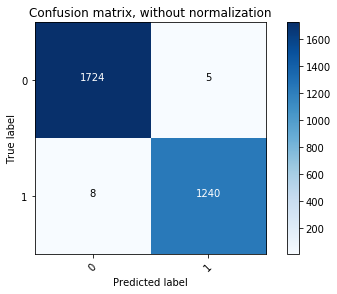

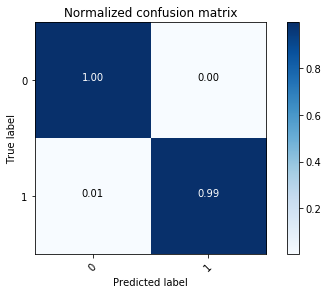

TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[183  10]
 [  2 137]]
Normalized confusion matrix
[[0.94818653 0.05181347]
 [0.01438849 0.98561151]]


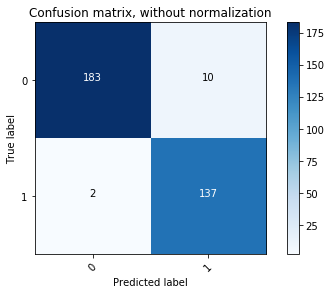

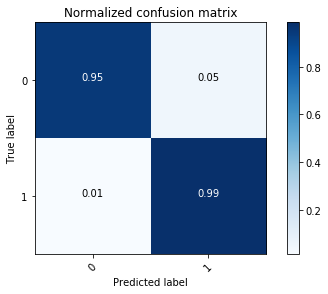

In [42]:
# draw confusion matrix
print("TRAIN CONFUSION MATRIX")
y_pred_train = model.predict(X_train)
print_confusion_matrix(X_train, y_train.argmax(axis=1), y_pred_train.argmax(axis=1), categories_count=CATEGORIES_COUNT)
print("TEST CONFUSION MATRIX")
y_pred_test = model.predict(X_test)
print_confusion_matrix(X_test, y_test.argmax(axis=1), y_pred_test.argmax(axis=1), categories_count=CATEGORIES_COUNT)

In [43]:
print("Val accuracy: %.4f" % (test_scores[1]))

Val accuracy: 0.9639


In [44]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

file_path_train_X = "./LSTM_results_word_emb/France_ByMeaningLarge_4th_net_train_X_100_words.npy"
file_path_test_X = "./LSTM_results_word_emb/France_ByMeaningLarge_4th_net_test_X_100_words.npy"

file_path_train_y = "./LSTM_results_word_emb/France_ByMeaningLarge_4th_net_train_y.npy"
file_path_test_y = "./LSTM_results_word_emb/France_ByMeaningLarge_4th_net_test_y.npy"

np.save(file_path_train_X, train_predict)
np.save(file_path_test_X, test_predict)
np.save(file_path_train_y, y_train)
np.save(file_path_test_y, y_test)

### 5

In [45]:
%%time
# and also with 1d-convolutional layer

categories_count = CATEGORIES_COUNT

model = Sequential()
model.add(Conv1D(input_shape=X_train[0].shape, filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dense(categories_count, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=0, mode='auto')
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=100, callbacks=[callback])

# Final evaluation of the model
test_scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f" % (test_scores[1]))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 100, 32)           28832     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 32)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 202       
Total params: 82,234
Trainable params: 82,234
Non-trainable params: 0
_________________________________________________________________
None
Train on 2977 samples, validate on 332 samples
Epoch 1/200
2977/2977 [==============================] - 17s 6ms/step - loss: 0.6772 - acc: 0.5808 - val_loss: 0.6954 - val_acc: 0.5813
Epoch 2/200
2977/2977 [==============================] - 13s 4ms/step - loss: 0.67

TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[1729    0]
 [   1 1247]]
Normalized confusion matrix
[[1.00000000e+00 0.00000000e+00]
 [8.01282051e-04 9.99198718e-01]]


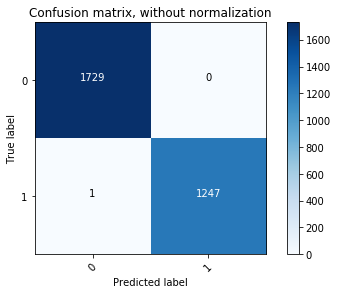

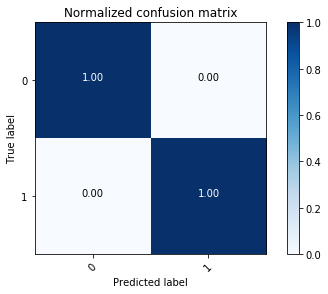

TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[189   4]
 [  7 132]]
Normalized confusion matrix
[[0.97927461 0.02072539]
 [0.05035971 0.94964029]]


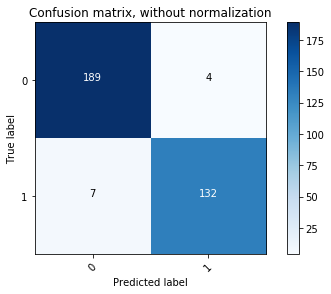

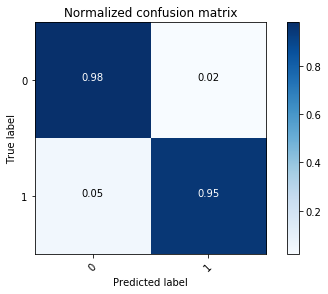

In [46]:
# draw confusion matrix
print("TRAIN CONFUSION MATRIX")
y_pred_train = model.predict(X_train)
print_confusion_matrix(X_train, y_train.argmax(axis=1), y_pred_train.argmax(axis=1), categories_count=CATEGORIES_COUNT)
print("TEST CONFUSION MATRIX")
y_pred_test = model.predict(X_test)
print_confusion_matrix(X_test, y_test.argmax(axis=1), y_pred_test.argmax(axis=1), categories_count=CATEGORIES_COUNT)

In [47]:
print("Val accuracy: %.4f" % (test_scores[1]))

Val accuracy: 0.9669


In [48]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

file_path_train_X = "./LSTM_results_word_emb/France_ByMeaningLarge_5th_net_train_X_100_words.npy"
file_path_test_X = "./LSTM_results_word_emb/France_ByMeaningLarge_5th_net_test_X_100_words.npy"

file_path_train_y = "./LSTM_results_word_emb/France_ByMeaningLarge_5th_net_train_y.npy"
file_path_test_y = "./LSTM_results_word_emb/France_ByMeaningLarge_5th_net_test_y.npy"

np.save(file_path_train_X, train_predict)
np.save(file_path_test_X, test_predict)
np.save(file_path_train_y, y_train)
np.save(file_path_test_y, y_test)

### 6

In [49]:
%%time

categories_count = CATEGORIES_COUNT

model = Sequential()
model.add(Conv1D(input_shape=X_train[0].shape, filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100, recurrent_dropout=0.2))
model.add(Dense(categories_count, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=0, mode='auto')
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=100, callbacks=[callback])

# Final evaluation of the model
test_scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f" % (test_scores[1]))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 100, 32)           28832     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 50, 32)            0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 202       
Total params: 82,234
Trainable params: 82,234
Non-trainable params: 0
_________________________________________________________________
None
Train on 2977 samples, validate on 332 samples
Epoch 1/200
2977/2977 [==============================] - 17s 6ms/step - loss: 0.6772 - acc: 0.5771 - val_loss: 0.6918 - val_acc: 0.5813
Epoch 2/200
2977/2977 [==============================] - 14s 5ms/step - loss: 0.67

TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[1728    1]
 [   5 1243]]
Normalized confusion matrix
[[9.99421631e-01 5.78368999e-04]
 [4.00641026e-03 9.95993590e-01]]


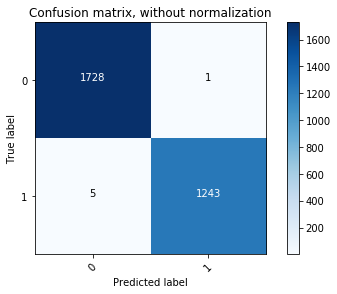

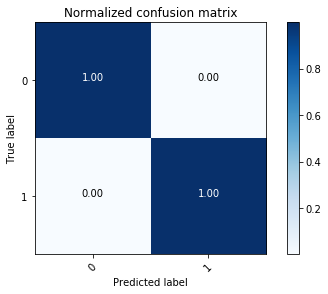

TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[185   8]
 [  1 138]]
Normalized confusion matrix
[[0.95854922 0.04145078]
 [0.00719424 0.99280576]]


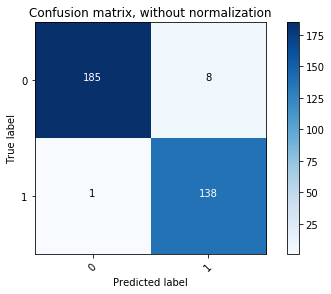

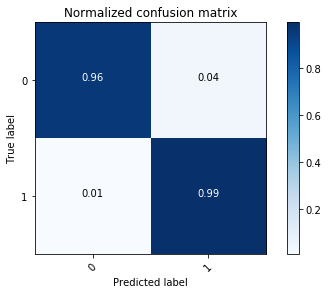

In [50]:
# draw confusion matrix
print("TRAIN CONFUSION MATRIX")
y_pred_train = model.predict(X_train)
print_confusion_matrix(X_train, y_train.argmax(axis=1), y_pred_train.argmax(axis=1), categories_count=CATEGORIES_COUNT)
print("TEST CONFUSION MATRIX")
y_pred_test = model.predict(X_test)
print_confusion_matrix(X_test, y_test.argmax(axis=1), y_pred_test.argmax(axis=1), categories_count=CATEGORIES_COUNT)

In [51]:
print("Val accuracy: %.4f" % (test_scores[1]))

Val accuracy: 0.9729


In [52]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

file_path_train_X = "./LSTM_results_word_emb/France_ByMeaningLarge_6th_net_train_X_100_words.npy"
file_path_test_X = "./LSTM_results_word_emb/France_ByMeaningLarge_6th_net_test_X_100_words.npy"

file_path_train_y = "./LSTM_results_word_emb/France_ByMeaningLarge_6th_net_train_y.npy"
file_path_test_y = "./LSTM_results_word_emb/France_ByMeaningLarge_6th_net_test_y.npy"

np.save(file_path_train_X, train_predict)
np.save(file_path_test_X, test_predict)
np.save(file_path_train_y, y_train)
np.save(file_path_test_y, y_test)